# Classification of multiple spyral blobs of points using linear and non linear regression

**Learning Source:**

freeCodeCamp.org : PyTorch for Deep Learning & Machine Learning – Full Course 

This example is a example of implementation of multi-class classification example from the provided tutorial. In this perticular example we will see a different dataset of blobs of data that have a spiral structure. We will then test the performance of linear and non linear classification models on this dataset. This is part of the assignment section of the set reference videos and not provided in the video reference.

**References:**
- Link to resource: https://www.youtube.com/watch?v=V_xro1bcAuA
- https://pytorch.org/tutorials/beginner/ptcheat.html
- https://www.geeksforgeeks.org/machine-learning

## 01. Setup Environment

### 01.01 Setting up environment

In [ ]:
# install basic packages required for the project
%conda install numpy pandas matplotlib
%conda install pytorch -c pytorch
%conda install scikit-learn
%conda install tqdm

### 01.02 Importing Libraries to python

In [1]:
import torch

torch.__version__

'2.5.1'

### 01.03 Setting up Device Agnostic code and device selection

In [2]:
#setup devices agnostic code
print("Setting up device agnostic ...")
if torch.cuda.is_available():       # Check if cuda available
    device = torch.device("cuda")   # Set device as cuda
elif torch.mps.is_available():      # Check if mps available
    device = torch.device("mps")    # Set device as mps
else:                               # Default device selection
    device = torch.device("cpu")    # Set device as cpu, Default behavour

print(f"Selected device for processing : {device}")

Setting up device agnostic ...
Selected device for processing : mps


### 01.04 Setting up some Helper Functions

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np



def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


## 02. Data Preparation and Loading

To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage example provided in  [`case study`](https://cs231n.github.io/neural-networks-case-study/) to generate the data.

### 02.01 Preparing (Generating) data

tensor([[-0.0000,  0.0000],
        [ 0.0003,  0.0012],
        [-0.0009,  0.0023],
        [-0.0006,  0.0037],
        [-0.0003,  0.0050]]) tensor([0, 0, 0, 0, 0])


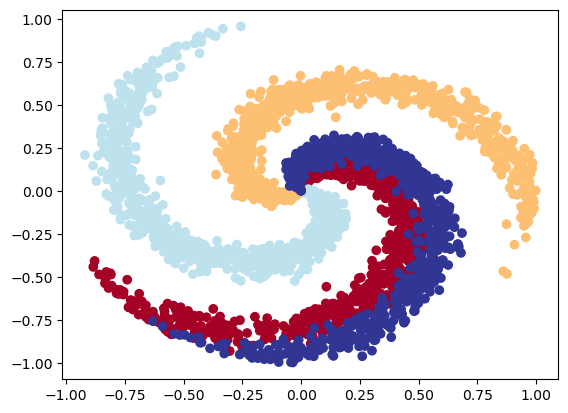

In [64]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

def makeSpiralBlobs(n_samples:int, k:int, dim:int = 2):
    """
        Function to make blobs of data that are structured in a spiral manner with dim inputs and k classes.
        
        Args:
            n_samples: number of samples
            dim: dimensionality of the data (features)
            k: number of classes
        
        Returns:
           X: numpy array of shape [n_samples, dim] containing the generated data points
           y: numpy array of shape [n_samples] containing the labels for each sample
    """
    X = np.zeros((n_samples*k, dim))
    y = np.zeros(n_samples*k, dtype='uint8')
    for i in range(k):
        ix = range(n_samples*i, n_samples*(i+1))
        r = np.linspace(0.0, 1, n_samples) # radius
        t = np.linspace(i*4, (i+1)*4, n_samples) + np.random.randn(n_samples)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = i
    return X, y

#Data Hyper Parameters
NUM_SAMPLES = 800
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multi-class data blobs 

X_blob, y_blob = makeSpiralBlobs(n_samples=NUM_SAMPLES,
                                 k=NUM_CLASSES,
                                 dim=NUM_FEATURES)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5],y_blob[:5])

plt.Figure(figsize=(10, 7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

### 02.02 Train Test Split data

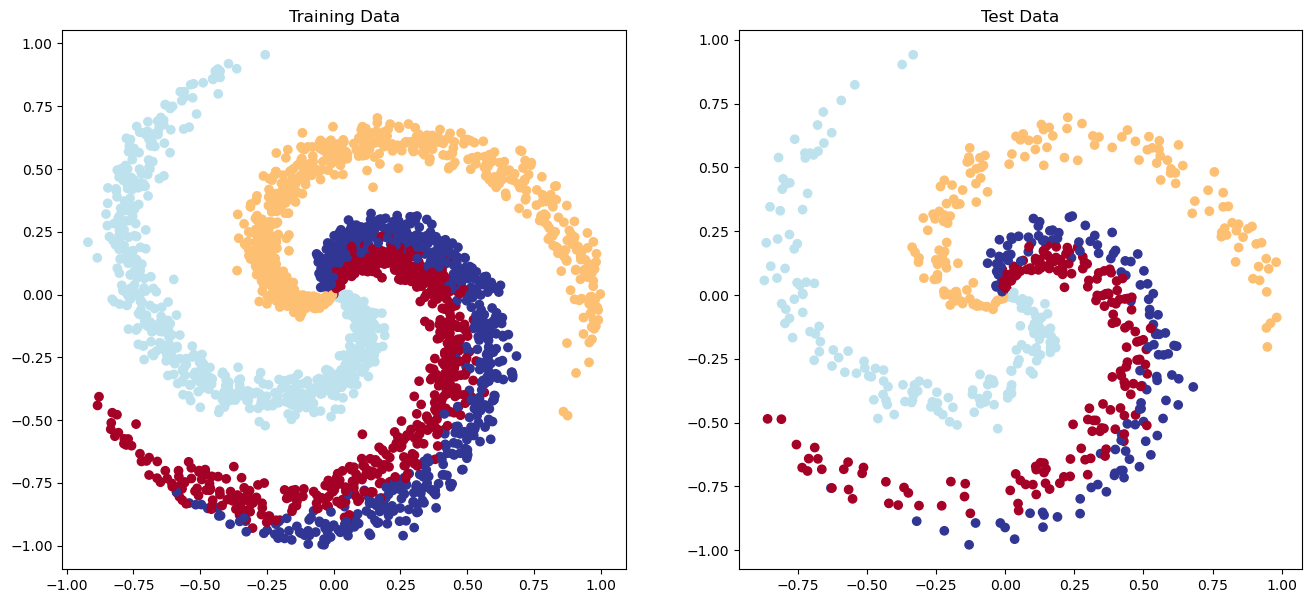

In [65]:
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_SEED)

plt.figure(figsize=(16, 7))
plt.subplot(1,2,1)
plt.title("Training Data")
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.RdYlBu)
plt.subplot(1,2,2)
plt.title("Test Data")
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap=plt.cm.RdYlBu)

## 03. Build a Model

let's create a subclass of `nn.Module` that takes in three hyperparameters:
* `input_features` - the number of `X` features coming into the model.
* `output_features` - the ideal numbers of output features we'd like (this will be equivalent to `NUM_CLASSES` or the number of classes in your multi-class classification problem).
* `hidden_units` - the number of hidden neurons we'd like each hidden layer to use.

### 03.01 Setting up Helper Functions for Model

### 03.02 Writing the model Class

In [102]:
import torch
from torch import nn

class BlobLinearModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)
    
class BlobNonLinearModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

### 03.03 Setting up HyperParameters

In [103]:

IN_FEATURES = NUM_FEATURES
HIDDEN_UNITS = 8
OUT_FEATURES = NUM_CLASSES

lr = 0.1

model_linear = BlobLinearModel(input_features=IN_FEATURES,
                          output_features=OUT_FEATURES,
                          hidden_units=HIDDEN_UNITS)

model_non_linear = BlobNonLinearModel(input_features=IN_FEATURES,
                          output_features=OUT_FEATURES,
                          hidden_units=HIDDEN_UNITS)

## 04. Training

Feel free to reference the [ML Activation function cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html) 

### 04.00 Setting up helper methods for training

In [104]:
import torch
from timeit import default_timer as timer 

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """
        Calculates accuracy between truth labels and predictions.

        Args:
            y_true (torch.Tensor): Truth labels for predictions.
            y_pred (torch.Tensor): Predictions to be compared to predictions.

        Returns:
            [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def logitsToPredictionActivationFn(logits, dim=1):
    """
        Activation function that converts logits to prediction probabilities and then to prediction labels

        Args:
            logits (torch.Tensor): Logits output from the model.
            dim (int): Dimension along which to apply the softmax function.
        
        Returns:
            [torch.int]: Prediction labels.
    """
    return torch.softmax(logits, dim).argmax(dim)

def train_step(model: torch.nn.Module,
                  X: torch.Tensor,
                  y: torch.Tensor,
                  loss_fn: torch.nn.Module,
                  optimizer: torch.optim.Optimizer,
                  device: torch.device = device) -> tuple:
    """
        Training step for a model. 

        Args:
            model (torch.nn.Module): Model to train. 
            x (torch.Tensor): Input Features. 
            y (torch.Tensor): Target Labels. 
            loss_fn (torch.nn.Module): Loss Function to use for training. 
            optimizer (torch.optim.Optimizer): Optimizer to use for training. 
            device (torch.device, optional): Device to train on. Defaults to device.
        
        Returns:
            (torch.float, torch.float): Training Loss and Accuracy tuple. 
    """
    
    # train_loss, train_acc = 0.0, 0.0
    # Move model and data to device
    model.to(device)
    X, y = X.to(device), y.to(device)

    model.train()                                       # Set model to training mode
    logits = model(X)                                   # Forward Pass through model
    pred = logitsToPredictionActivationFn(logits)       # Apply softmax to get prediction probability and get prediction index
    
    train_loss = loss_fn(logits,y)                      # Calculate loss, with BCEWithLogitsLoss we use logits insted of pred
    train_acc = accuracy_fn(y_true=y, y_pred=pred)      # Calculate accuracy

    optimizer.zero_grad()                               # Clear gradients from previous iteration

    train_loss.backward()                               # Back propogation

    optimizer.step()                                    # Gradient Decent, update weights

    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              X: torch.Tensor,
              y: torch.Tensor,
              loss_fn: torch.nn.Module,
              device: torch.device = device) -> tuple:
    """
        Make predictions on a test set and calculate accuracy

        Args:
            model (torch.nn.Module): Model to train. 
            X (torch.Tensor): Input Features. 
            y (torch.Tensor): Target Labels. 
            loss_fn (torch.nn.Module): Loss Function to use for training.
            device (torch.device, optional): Device to train on. Defaults to device.
        Returns:
            (torch.float, torch.float): Testing Loss and Accuracy tuple. 
    """
    test_loss, test_acc = 0.0, 0.0
    # move model and daa to device
    model.to(device)
    X, y = X.to(device), y.to(device)

    model.eval()                                            # Set model to evaluation mode
    with torch.inference_mode():                            # Disable gradient calculation for performance reasons
        logits = model(X)                                   # Forward Pass through model
        pred = logitsToPredictionActivationFn(logits)       # Apply softmax to get prediction probability and get prediction index
        
        test_loss = loss_fn(logits,y)                       # Calculate loss, as we use BCEWithLogitsLoss we use logits insted of pred
        test_acc = accuracy_fn(y_true=y, y_pred=pred)       # Calculate accuracy
    
    return test_loss, test_acc


### 04.01 Setting up Loss Function and Optimizer

Different problem types require different loss functions. 

For example, for a regression problem (predicting a number) you might use mean absolute error (MAE) loss.

And for a binary classification problem (like ours), you'll often use [binary cross entropy](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a) as the loss function.

However, the same optimizer function can often be used across different problem spaces.

For example, the stochastic gradient descent optimizer (SGD, `torch.optim.SGD()`) can be used for a range of problems, and the same applies to the Adam optimizer (`torch.optim.Adam()`). 

| Loss function/Optimizer | Problem type | PyTorch Code |
| ----- | ----- | ----- |
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) |
| Adam Optimizer | Classification, regression, many others. | [`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) |
| Binary cross entropy loss | Binary classification | [`torch.nn.BCELossWithLogits`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) or [`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) |
| Cross entropy loss | Multi-class classification | [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) |
| Mean absolute error (MAE) or L1 Loss | Regression | [`torch.nn.L1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) | 
| Mean squared error (MSE) or L2 Loss | Regression | [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) |  

*Table of various loss functions and optimizers, there are more but these are some common ones you'll see.*

Since we're working with a binary classification problem, let's use a binary cross entropy loss function.

> **Note:** Recall a **loss function** is what measures how *wrong* your model predictions are, the higher the loss, the worse your model.
>
> Also, PyTorch documentation often refers to loss functions as "loss criterion" or "criterion", these are all different ways of describing the same thing.

PyTorch has two binary cross entropy implementations:
1. [`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
2. [`torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) - This is the same as above except it has a sigmoid layer ([`nn.Sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)) built-in (we'll see what this means soon).

Which one should you use? 

The [documentation for `torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) states that it's more numerically stable than using `torch.nn.BCELoss()` after a `nn.Sigmoid` layer. 

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of `nn.Sigmoid` and `torch.nn.BCELoss()` but that is beyond the scope of this notebook.

Knowing this, let's create a loss function and an optimizer. 

For the optimizer we'll use `torch.optim.SGD()` to optimize the model parameters with learning rate 0.1.

> **Note:** There's a [discussion on the PyTorch forums about the use of `nn.BCELoss` vs. `nn.BCEWithLogitsLoss`](https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/4). It can be confusing at first but as with many things, it becomes easier with practice.

In [105]:

loss_fn_linear = nn.CrossEntropyLoss()
loss_fn_non_linear = nn.CrossEntropyLoss()

optimizer_linear = torch.optim.SGD(model_linear.parameters(), lr=lr)
optimizer_nonlinear = torch.optim.SGD(model_non_linear.parameters(),lr=lr)

## 04.02 Getting prediction probabilities of multi-class PyTorch model

We have a loss function and optimizer selected for out model, lets do a forward pass through the model once to see the output logits

In [106]:
model_linear.eval()
model_non_linear.eval()
with torch.inference_mode():
    logit_linear = model_linear(X_test)
    logit_non_linear = model_non_linear(X_test)

print(logit_linear[:5], logit_linear.shape)
print(logit_non_linear[:5], logit_non_linear.shape)

tensor([[ 0.3531, -0.3196,  0.3642,  0.3357],
        [ 0.1876, -0.2635,  0.1898,  0.1621],
        [ 0.3689, -0.2268,  0.3950,  0.2783],
        [ 0.2162, -0.2369,  0.2253,  0.1648],
        [ 0.1283, -0.2664,  0.1241,  0.1173]]) torch.Size([640, 4])
tensor([[ 0.3157, -0.6028,  0.2042, -0.3695],
        [ 0.3545, -0.5151,  0.2246, -0.2950],
        [ 0.3907, -0.5003,  0.2870, -0.3399],
        [ 0.3774, -0.4892,  0.2526, -0.2941],
        [ 0.3533, -0.5094,  0.2128, -0.2766]]) torch.Size([640, 4])


Wonderful the output generates output for one value for each class of out labels. Currently out output are logits, but if we want to figure out exactly what label is given by our output samples, we need to go from `logits -> prediction probabilities -> prediction labels` just like we did with the binary classification problem, that is where the [softmax activation function](https://en.wikipedia.org/wiki/Softmax_function) comes into play.

The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes. After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to). These prediction probabilities are essentially saying how much the model thinks the target X sample (the input) maps to each class.Since there's one value for each class in `y_pred_probs`, the index of the *highest* value is the class the model thinks the specific data sample *most* belongs to.

We can check which index has the highest value using `torch.argmax()`.

In [107]:
# pass raw logits from each model through a softmax activation function
y_pred_prob_linear = torch.softmax(logit_linear,dim=1)
y_pred_prob_non = torch.softmax(logit_non_linear, dim=1)

# lets check the first element of prediction probabilities
print(y_pred_prob_linear[0], y_pred_prob_linear[0])

# lets check that how much sample adds up to
print(torch.sum(y_pred_prob_linear[0]), torch.sum(y_pred_prob_linear[0]))

# lets now find the indes of the highest value ie the y labels 
print(torch.argmax(y_pred_prob_linear[0]), torch.argmax(y_pred_prob_non[0]))

tensor([0.2854, 0.1456, 0.2886, 0.2804]) tensor([0.2854, 0.1456, 0.2886, 0.2804])
tensor(1.) tensor(1.)
tensor(2) tensor(0)


As you can see the output show 3 and 0 for the features(X) of index 0, predicting that the features most probably likly belongs to the class 3 by the linear model and class 0 by the non linear model. Ofcourse this may not be correct and is just random guesssing as it has got a 25% chance to be correct. But we can improve this by training the model.

> **Note:** To summarize the above, a model's raw output is referred to as **logits**.
> 
> For a multi-class classification problem, to turn the logits into **prediction probabilities**, you use the softmax activation function (`torch.softmax`).
>
> The index of the value with the highest **prediction probability** is the class number the model thinks is *most* likely given the input features for that sample (although this is a prediction, it doesn't mean it will be correct).

### 04.02 Training Model

Okay, now we've got a loss function and optimizer ready to go, let's train a model.

Steps in training:

<details>
    <summary>PyTorch training loop steps</summary>
    <ol>
        <li><b>Forward pass</b> - The model goes through all of the training data once, performing its
            <code>forward()</code> function
            calculations (<code>model(x_train)</code>).
        </li>
        <li><b>Calculate the loss</b> - The model's outputs (predictions) are compared to the ground truth and evaluated
            to see how
            wrong they are (<code>loss = loss_fn(y_pred, y_train</code>).</li>
        <li><b>Zero gradients</b> - The optimizers gradients are set to zero (they are accumulated by default) so they
            can be
            recalculated for the specific training step (<code>optimizer.zero_grad()</code>).</li>
        <li><b>Perform backpropagation on the loss</b> - Computes the gradient of the loss with respect for every model
            parameter to
            be updated (each parameter
            with <code>requires_grad=True</code>). This is known as <b>backpropagation</b>, hence "backwards"
            (<code>loss.backward()</code>).</li>
        <li><b>Step the optimizer (gradient descent)</b> - Update the parameters with <code>requires_grad=True</code>
            with respect to the loss
            gradients in order to improve them (<code>optimizer.step()</code>).</li>
    </ol>
</details>



#### 04.02.01 Training linear model

Epochs:   1%|          | 10/1000 [00:00<00:10, 95.64it/s]

Epoch: 0
---------
Training Loss: 1.40213 | Train Acc:32.58% | Test Loss: 1.39757 | Test Acc:36.25%


Epochs:  11%|█▏        | 114/1000 [00:01<00:08, 104.48it/s]

Epoch: 100
---------
Training Loss: 1.17466 | Train Acc:38.71% | Test Loss: 1.17232 | Test Acc:38.71%


Epochs:  22%|██▏       | 215/1000 [00:02<00:08, 95.91it/s] 

Epoch: 200
---------
Training Loss: 1.05421 | Train Acc:39.65% | Test Loss: 1.05402 | Test Acc:39.65%


Epochs:  31%|███▏      | 314/1000 [00:03<00:06, 102.53it/s]

Epoch: 300
---------
Training Loss: 1.04910 | Train Acc:39.34% | Test Loss: 1.04909 | Test Acc:39.34%


Epochs:  42%|████▏     | 419/1000 [00:04<00:05, 106.04it/s]

Epoch: 400
---------
Training Loss: 1.04897 | Train Acc:39.34% | Test Loss: 1.04897 | Test Acc:39.34%


Epochs:  52%|█████▏    | 522/1000 [00:05<00:03, 123.20it/s]

Epoch: 500
---------
Training Loss: 1.04896 | Train Acc:39.34% | Test Loss: 1.04896 | Test Acc:39.34%


Epochs:  63%|██████▎   | 628/1000 [00:06<00:02, 166.91it/s]

Epoch: 600
---------
Training Loss: 1.04896 | Train Acc:39.34% | Test Loss: 1.04896 | Test Acc:39.34%


Epochs:  72%|███████▏  | 723/1000 [00:06<00:01, 140.17it/s]

Epoch: 700
---------
Training Loss: 1.04896 | Train Acc:39.34% | Test Loss: 1.04896 | Test Acc:39.34%


Epochs:  83%|████████▎ | 830/1000 [00:07<00:01, 130.79it/s]

Epoch: 800
---------
Training Loss: 1.04896 | Train Acc:39.34% | Test Loss: 1.04896 | Test Acc:39.34%


Epochs:  92%|█████████▏| 918/1000 [00:08<00:00, 164.23it/s]

Epoch: 900
---------
Training Loss: 1.04896 | Train Acc:39.34% | Test Loss: 1.04896 | Test Acc:39.34%


Epochs: 100%|██████████| 1000/1000 [00:08<00:00, 111.24it/s]


Train time on mps: 8.991 seconds


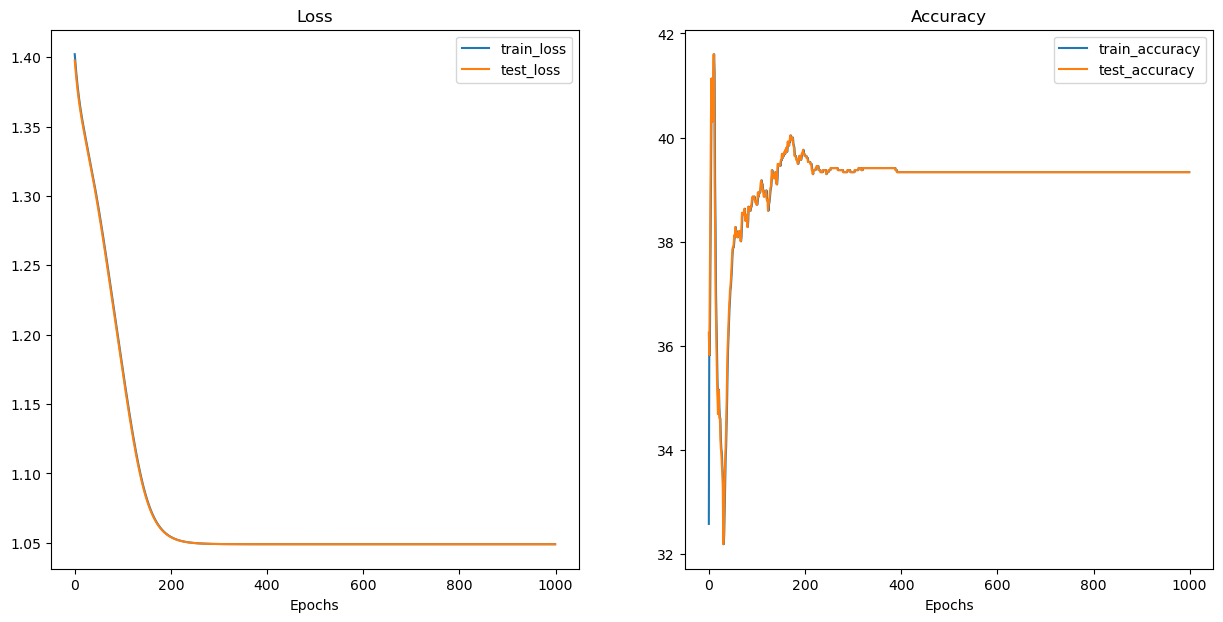

In [108]:
from timeit import default_timer as timer
from tqdm import tqdm

torch.manual_seed(RANDOM_SEED)

epochs_linear = 1000
results_linear = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
    }

timer_start_time = timer()

for epoch in tqdm(range(epochs_linear), desc="Epochs"):
    train_loss, train_acc = train_step(model=model_linear,
                                       X=X_train,
                                       y=y_train,
                                       loss_fn=loss_fn_linear,
                                       optimizer=optimizer_linear,
                                       device=device)
    test_loss, test_acc = test_step(model=model_linear,
                                    X=X_train,
                                    y=y_train,
                                    loss_fn=loss_fn_linear,
                                    device=device)
    # Print out what's happening every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}\n---------")
        print(f"Training Loss: {train_loss:.5f} | Train Acc:{train_acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc:{test_acc:.2f}%")
    results_linear["train_loss"].append(train_loss.cpu().detach().numpy())
    results_linear['train_acc'].append(train_acc)
    results_linear["test_loss"].append(test_loss.cpu().detach().numpy())
    results_linear["test_acc"].append(test_acc)

timer_end_time = timer()

total_training_time_model_0 = print_train_time(start=timer_start_time,
                                               end=timer_end_time,
                                               device=device)

plot_loss_curves(results=results_linear)

#### 04.02.02 Training non linear model

Epochs:   0%|          | 20/5000 [00:00<00:53, 92.59it/s]

Epoch: 0
---------
Training Loss: 1.44994 | Train Acc:23.91% | Test Loss: 1.44200 | Test Acc:23.91%


Epochs:  11%|█         | 529/5000 [00:03<00:25, 177.99it/s]

Epoch: 500
---------
Training Loss: 0.96720 | Train Acc:47.27% | Test Loss: 0.96683 | Test Acc:47.34%


Epochs:  20%|██        | 1021/5000 [00:06<00:24, 162.05it/s]

Epoch: 1000
---------
Training Loss: 0.79279 | Train Acc:60.00% | Test Loss: 0.79254 | Test Acc:59.96%


Epochs:  31%|███       | 1529/5000 [00:10<00:24, 143.22it/s]

Epoch: 1500
---------
Training Loss: 0.72107 | Train Acc:61.95% | Test Loss: 0.72099 | Test Acc:61.95%


Epochs:  41%|████      | 2026/5000 [00:13<00:18, 164.55it/s]

Epoch: 2000
---------
Training Loss: 0.69444 | Train Acc:62.70% | Test Loss: 0.69436 | Test Acc:62.93%


Epochs:  51%|█████     | 2538/5000 [00:17<00:13, 183.53it/s]

Epoch: 2500
---------
Training Loss: 0.67411 | Train Acc:62.77% | Test Loss: 0.67445 | Test Acc:63.87%


Epochs:  60%|██████    | 3012/5000 [00:20<00:19, 99.70it/s] 

Epoch: 3000
---------
Training Loss: 0.66002 | Train Acc:66.05% | Test Loss: 0.66082 | Test Acc:64.65%


Epochs:  70%|██████▉   | 3495/5000 [00:25<00:10, 137.21it/s]

Epoch: 3500
---------
Training Loss: 0.63312 | Train Acc:69.02% | Test Loss: 0.63401 | Test Acc:68.52%


Epochs:  80%|████████  | 4024/5000 [00:29<00:05, 188.45it/s]

Epoch: 4000
---------
Training Loss: 0.59802 | Train Acc:71.09% | Test Loss: 0.60130 | Test Acc:69.18%


Epochs:  90%|█████████ | 4520/5000 [00:32<00:02, 192.21it/s]

Epoch: 4500
---------
Training Loss: 0.53984 | Train Acc:73.48% | Test Loss: 0.54005 | Test Acc:72.66%


Epochs: 100%|██████████| 5000/5000 [00:35<00:00, 142.07it/s]


Train time on mps: 35.170 seconds


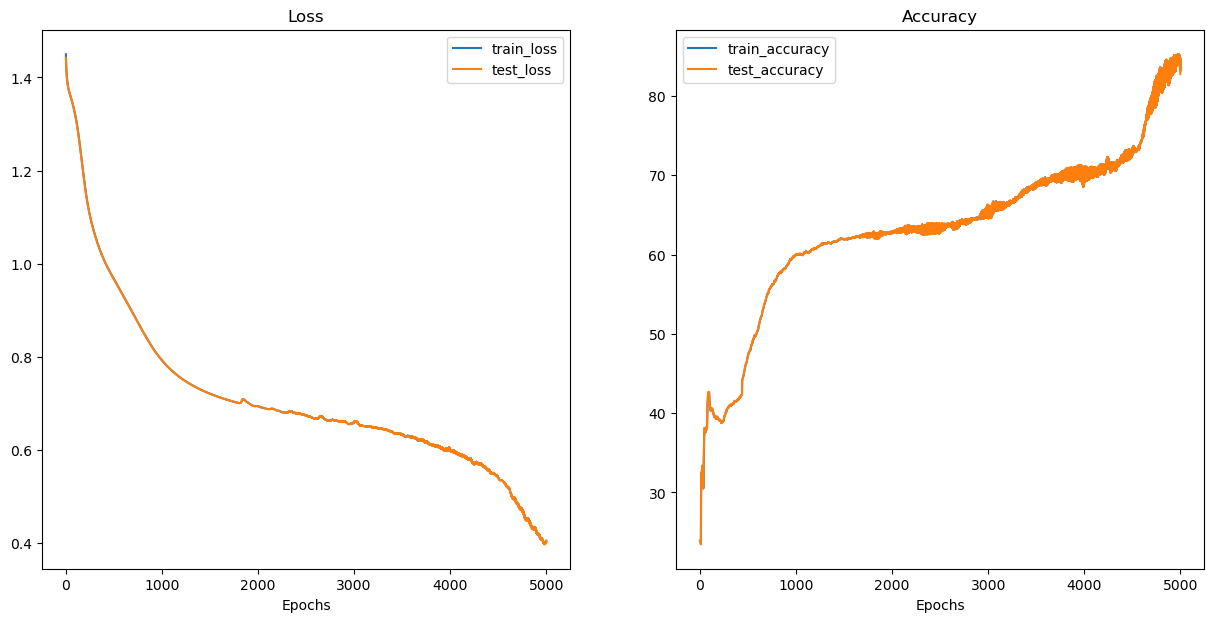

In [109]:
from timeit import default_timer as timer
from tqdm import tqdm

torch.manual_seed(RANDOM_SEED)

epochs_non_linear = 5000
results_non_linear = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
    }

timer_start_time = timer()

for epoch in tqdm(range(epochs_non_linear), desc="Epochs"):
    train_loss, train_acc = train_step(model=model_non_linear,
                                       X=X_train,
                                       y=y_train,
                                       loss_fn=loss_fn_non_linear,
                                       optimizer=optimizer_nonlinear,
                                       device=device)
    test_loss, test_acc = test_step(model=model_non_linear,
                                    X=X_train,
                                    y=y_train,
                                    loss_fn=loss_fn_non_linear,
                                    device=device)
    # Print out what's happening every 100 epochs
    if epoch % 500 == 0:
        print(f"Epoch: {epoch}\n---------")
        print(f"Training Loss: {train_loss:.5f} | Train Acc:{train_acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc:{test_acc:.2f}%")
    results_non_linear["train_loss"].append(train_loss.cpu().detach().numpy())
    results_non_linear['train_acc'].append(train_acc)
    results_non_linear["test_loss"].append(test_loss.cpu().detach().numpy())
    results_non_linear["test_acc"].append(test_acc)

timer_end_time = timer()

total_training_time_model_0 = print_train_time(start=timer_start_time,
                                               end=timer_end_time,
                                               device=device)
plot_loss_curves(results=results_non_linear)

### 04.03 Evaluating the Model

In [110]:
model_linear.eval()
model_non_linear.eval()
with torch.inference_mode():
    y_logits_linear = model_linear(X_test.to(device))
    y_logits_non = model_non_linear(X_test.to(device))

# lets check the logits from our model now
print(y_logits_linear[:5], y_logits_non[:5])

# check prediction labels for first 5 elements
print(logitsToPredictionActivationFn(y_logits_linear)[:5], logitsToPredictionActivationFn(y_logits_non)[:5])

tensor([[-0.9151,  1.8249,  3.1475, -1.5270],
        [-0.2202,  0.5728,  0.2990, -0.1359],
        [ 0.3994, -0.6814,  2.8392, -0.5484],
        [ 0.1714, -0.1839,  0.5772,  0.0353],
        [-0.2952,  0.7402, -0.5849,  0.1017]], device='mps:0') tensor([[ -9.2721,   1.8273,   3.5544,   0.1853],
        [  0.4022,  -1.2973,  -1.6384,   0.8775],
        [-13.3695,   5.7064,  10.3766,  -9.0815],
        [ -5.4835,   3.5802,   3.4885,  -5.2589],
        [  1.6278,  -1.8968,  -3.3438,   2.0601]], device='mps:0')
tensor([2, 1, 2, 2, 1], device='mps:0') tensor([2, 3, 2, 1, 3], device='mps:0')


Let us plot the output of the model to visualize them better

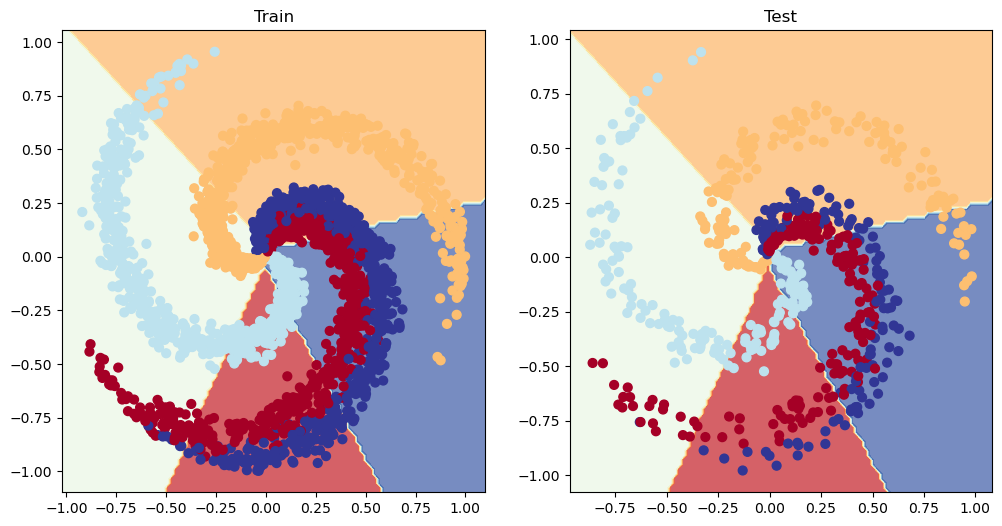

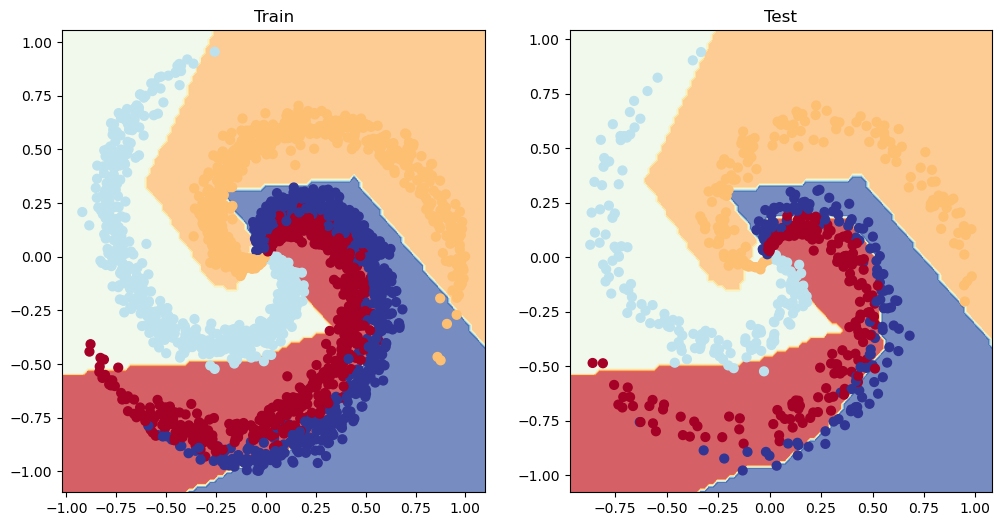

In [111]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_linear, X_train.to(device), y_train.to(device))
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_linear, X_test.to(device), y_test.to(device))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_non_linear, X_train.to(device), y_train.to(device))
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_non_linear, X_test.to(device), y_test.to(device))

### 04.04 Some more classification metrices

So far we've only covered a couple of ways of evaluating a classification model (accuracy, loss and visualizing predictions).

These are some of the most common methods you'll come across and are a good starting point.

However, you may want to evaluate your classification model using more metrics such as the following:

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`torchmetrics.Accuracy()`](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html#id3) or [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`torchmetrics.Precision()`](https://torchmetrics.readthedocs.io/en/stable/classification/precision.html#id4) or [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`torchmetrics.Recall()`](https://torchmetrics.readthedocs.io/en/stable/classification/recall.html#id5) or [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`torchmetrics.F1Score()`](https://torchmetrics.readthedocs.io/en/stable/classification/f1_score.html#f1score) or [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html#confusionmatrix) or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

Scikit-Learn (a popular and world-class machine learning library) has many implementations of the above metrics and you're looking for a PyTorch-like version, check out [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/), especially the [TorchMetrics classification section](https://torchmetrics.readthedocs.io/en/stable/pages/classification.html). 

Let's try the `torchmetrics.Accuracy` metric out.




In [112]:
try:
    from torchmetrics import Accuracy
except:
    %conda install torchmetrics # for version check https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog
    from torchmetrics import Accuracy

model_linear.eval()
model_non_linear.eval()
with torch.inference_mode():
    logit_linear = model_linear(X_test)
    logit_non_linear = model_non_linear(X_test)

y_pred_linear = logitsToPredictionActivationFn(logit_linear)
y_pred_non = logitsToPredictionActivationFn(logit_non_linear)

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_pred_linear, y_test), torchmetrics_accuracy(y_pred_non, y_test)

(tensor(0.4047, device='mps:0'), tensor(0.8484, device='mps:0'))

## 05. Storing & Loading Model

### 05.01 Saving Model state to file

In [113]:
from pathlib import Path
MODEL_PATH = Path("saved_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_0_NAME = "002_LinearRegressionMultiClassClassificationModel.pth"
MODEL_0_SAVE_PATH = MODEL_PATH / MODEL_0_NAME

MODEL_1_NAME = "002_NonLinearRegressionMultiClassClassificationModel.pth"
MODEL_1_SAVE_PATH = MODEL_PATH / MODEL_1_NAME

print(f"Saving model LinearRegressionMultiClassClassificationModel to : {MODEL_0_SAVE_PATH}")
torch.save(obj=model_linear.state_dict(),
           f=MODEL_0_SAVE_PATH)
print("Done")

print(f"Saving model NonLinearRegressionMultiClassClassificationModel to : {MODEL_1_SAVE_PATH}")
torch.save(obj=model_non_linear.state_dict(),
           f=MODEL_1_SAVE_PATH)
print("Done")

Saving model LinearRegressionMultiClassClassificationModel to : saved_models/002_LinearRegressionMultiClassClassificationModel.pth
Done
Saving model NonLinearRegressionMultiClassClassificationModel to : saved_models/002_NonLinearRegressionMultiClassClassificationModel.pth
Done


### 05.02 Loading Model state from file

In [114]:
loaded_model = BlobLinearModel(input_features=IN_FEATURES,
                          output_features=OUT_FEATURES,
                          hidden_units=HIDDEN_UNITS)                 # Create an instance of the model
loaded_model.load_state_dict(torch.load(f=MODEL_0_SAVE_PATH)) # Load the saved state dict

loaded_model.to(device)

/var/folders/np/zcr9zsz525lfkvpm3z_lkfh00000gn/T/ipykernel_10772/1720219554.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=MOD

BlobLinearModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 05.03 Testing loaded model

In [115]:
# make prediction from loaded model
loaded_model.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model(X_test.to(device))

#make prediction from old model
model_linear.eval()
model_linear.to(device)
with torch.inference_mode():
  model_preds = model_linear(X_test.to(device))

torch.eq(loaded_model_preds, model_preds).all()               # check if predictions are the same

tensor(True, device='mps:0')

## 06. Conclusion

In this example we saw how we can utilize linear and non linear model to process multiple input (dependent) features and make prediction probability of those features for multiple class of labels (dependent). But the data had a spiral structure to it's feature.

In this example we tested both linear and non linear models for the classification and compared their respecive accuracies. We observed that for this type of dataset the linear model was not performing very good and seems to be stuck in the learning process, while the non linear model did excillent and adapted to the non linear characteristics of the data.

Additionally we saw that not all multi class classification data could be classified with linear models but non linear models adapt to the data features behaviours more to provide better predictions. We can see in the learning data there seems to be some possible optimization required for the data set to better the training of the model and get to the local minima much faster. We observed some spikes on the learning accuracy and loss during learning pointing to this finding. For better training performances further data processing methods could be applied.

Also our non linear model utilized `torch.nn.ReLU()`, while this activation function is not bad we could also experiment with other non linear activation functions in place for example `torch.nn.TanH()` or `torch.nn.Sigmoid()` to see differences in the results and possibly faster convergence. 